In [1]:
## data.py
import pandas as pd
import numpy as np
import torch

## Deep Ritz Method for Solving PDEs  
The Deep Ritz Method is a neural network-based approach for solving partial differential equations (PDEs) by reformulating the problem as a variational problem. This method leverages the expressive power of deep neural networks to approximate the solution of PDEs.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
def sample_interior(n_samples):
    """Sample points in the interior of the domain [0, 1] x [0, 1]."""
    x = np.random.uniform(0, 1, (n_samples, 1))
    y = np.random.uniform(0, 1, (n_samples, 1))
    return torch.tensor(np.hstack((x, y)), dtype=torch.float32).to(device)

def sample_boundary(n_samples, require_normals=False):
    """
    Sample points and normal vectorson the boundary of the domain [0, 1] x [0, 1].
    Returns:
        points: Tensor of shape (n_samples, 2) containing boundary points.
        normals: Tensor of shape (n_samples, 2) containing normal vectors at the boundary points.
    """
    n_samples_per_side = n_samples // 4
    # Four sides of the square
    left = np.stack((np.zeros((n_samples_per_side)), np.random.uniform(0, 1, (n_samples_per_side))), axis=1)
    right = np.stack((np.ones((n_samples_per_side)), np.random.uniform(0, 1, (n_samples_per_side))), axis=1)
    bottom = np.stack((np.random.uniform(0, 1, (n_samples_per_side)), np.zeros((n_samples_per_side))), axis=1)
    top = np.stack((np.random.uniform(0, 1, (n_samples_per_side)), np.ones((n_samples_per_side))), axis=1)
    
    #stack all boundary points
    points = np.vstack((left, right, bottom, top))
    normals = None
    
    if require_normals:
        #normal vectors 
        normals = np.vstack([
            np.tile([-1, 0], (n_samples_per_side, 1)),  # left
            np.tile([1, 0], (n_samples_per_side, 1)),
            np.tile([0, -1], (n_samples_per_side, 1)),  # bottom
            np.tile([0, 1], (n_samples_per_side, 1))   # top
        ])
    
    return (
        torch.tensor(points, dtype=torch.float32).to(device),
        torch.tensor(normals, dtype=torch.float32).to(device) if require_normals else None
    )
       

def generate_samples(n_interior, n_boundary, require_normals=False):
    """Generate interior and boundary samples."""
    interior_points = sample_interior(n_interior)
    boundary_points, boundary_normals = sample_boundary(n_boundary, require_normals)
    return interior_points, boundary_points, boundary_normals
    
    

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:

class ResBlock(nn.Module):
    def __init__(self, dim):
        super(ResBlock, self).__init__()
        self.linear1 = nn.Linear(dim, dim)
        self.linear2 = nn.Linear(dim, dim)
        self.activation = nn.Tanh()  # Tanh is smooth, essential for 4th order derivatives

    def forward(self, x):
        
        res = x
        out = self.activation(self.linear1(x))
        out = self.linear2(out)
        return self.activation(out + res)


class DRM_Model(nn.Module):
    def __init__(self):
        super(DRM_Model, self).__init__()
        # Increased width to 50 for better capacity on GPU
        self.input_layer = nn.Linear(2, 50)

        # 3 Residual Blocks
        self.resblocks = nn.Sequential(
            ResBlock(50),
            ResBlock(50),
            ResBlock(50),
            ResBlock(50),
            ResBlock(50),
        )

        self.output_layer = nn.Linear(50, 1)
        self.init_weights()

    def forward(self, x):
        out = torch.tanh(self.input_layer(x))
        out = self.resblocks(out)
        out = self.output_layer(out)
        return out
    def init_weights(self):
        if isinstance(self, nn.Linear):
            nn.init.xavier_norselfal_(self.weight)
            self.bias.data.fill_(0.0)

In [6]:
class U_FCN(nn.Module):
    def __init__(self,in__features : int = 2, out_features : int = 1, hidden_dims : list = [8,16,32,32,16,8]):
        super(U_FCN,self).__init__()
        layers = []
        input_dim = in__features
        for h_dim in hidden_dims:
            # layers.append(nn.BatchNorm1d(input_dim))
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.Tanh())
            # layers.append(nn.Dropout(p=0.2))
            input_dim = h_dim
        layers.append(nn.Linear(input_dim, out_features))
        self.network = nn.Sequential(*layers)
    def forward(self,x):
        return self.network(x)
    
# ---------------biharmonic operator ---------------

def biharmonic_operator(u : torch.Tensor,x : torch.Tensor):
    """
    Compute Δ²u = Laplacian(Laplacian(u)) using autograd.
    x : torch.Tensor (N,2) with required_grad = True
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    u_x = grad_u[:,0:1]
    u_y = grad_u[:,1:2]
    u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),create_graph=True)[0][:,0:1]
    u_yy = torch.autograd.grad(u_y,x,grad_outputs=torch.ones_like(u_y),create_graph=True)[0][:,1:2]
    lap_u = u_xx + u_yy
    
    grad_lap_u = torch.autograd.grad(lap_u,x,grad_outputs=torch.ones_like(lap_u),create_graph=True)[0]
    lap_u_x = grad_lap_u[:,0:1]
    lap_u_y = grad_lap_u[:,1:2]
    lap_u_xx = torch.autograd.grad(lap_u_x,x,grad_outputs=torch.ones_like(lap_u_x),create_graph=True)[0][:,0:1]
    lap_u_yy = torch.autograd.grad(lap_u_y,x,grad_outputs=torch.ones_like(lap_u_y),create_graph=True)[0][:,1:2]
    
    return lap_u_xx + lap_u_yy


### Penalized Energy Functional (P2)

$$
\mathcal{L}_\lambda(v)
= 
\frac{1}{2}\int_{\Omega} \lvert D^{2} v \rvert^{2}\, dx
\;-\;
\int_{\Omega} f\, v\, dx
\;-\;
\int_{\partial\Omega} g_{2}\, \frac{\partial v}{\partial n}\, ds
\;+\;
\frac{\lambda}{2}\int_{\partial\Omega} (v - g_{1})^{2}\, ds.  

$$

**Where:**

- $D^2 v$ is the Hessian matrix of $v$.  
- $|D^2 v|^2 = \sum_{i,j} \left( \frac{\partial^2 v}{\partial x_i \partial x_j} \right)^2$.


In [7]:
def compute_hessian( u : torch.Tensor, x : torch.Tensor):
    """
    Compute the Hessian matrix of u with respect to x.
    u : torch.Tensor (N,1)
    x : torch.Tensor (N,2) with required_grad = True
    return : torch.Tensor (N,2,2)
    """
    if not x.requires_grad:
        x.requires_grad = True
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    u_x = grad_u[:,0:1]
    u_y = grad_u[:,1:2]
    
    u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),create_graph=True)[0][:,0:1]
    u_xy = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),create_graph=True)[0][:,1:2]
    u_yx = torch.autograd.grad(u_y,x,grad_outputs=torch.ones_like(u_y),create_graph=True)[0][:,0:1]
    u_yy = torch.autograd.grad(u_y,x,grad_outputs=torch.ones_like(u_y),create_graph=True)[0][:,1:2]
    
    hessian = torch.stack([
        torch.cat([u_xx, u_xy], dim=1),
        torch.cat([u_yx, u_yy], dim=1)
    ], dim=1)  # Shape (N, 2, 2)
    
    return hessian

def compute_normal_derivative(u: torch.Tensor, x: torch.Tensor, normals: torch.Tensor):
    """
    Compute the normal derivative of u at boundary points.
    u : torch.Tensor (N,1)
    x : torch.Tensor (N,2) with required_grad = True
    normals : torch.Tensor (N,2)
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    normal_derivative = torch.sum(grad_u * normals, dim=1, keepdim=True)
    return normal_derivative

def compute_first_normal_derivative(u: torch.Tensor, x: torch.Tensor, normal: torch.Tensor):
    """
    Compute the first normal derivative ∂u/∂n using autograd.
    u : torch.Tensor (N,1) with required_grad = True
    x : torch.Tensor (N,2)
    normal : torch.Tensor (N,2)
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True    
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    du_dn = torch.sum(grad_u * normal, dim=1, keepdim=True) #TODO we could use dot product here
    
    return du_dn


def compute_second_normal_derivative(u: torch.Tensor, x: torch.Tensor, normal: torch.Tensor):
    """
    Compute the second normal derivative ∂²u/∂n² using autograd.
    u : torch.Tensor (N,1) with required_grad = True
    x : torch.Tensor (N,2)
    normal : torch.Tensor (N,2)
    return : torch.Tensor (N,1)
    """
    if not x.requires_grad:
        x.requires_grad = True
    
    grad_u = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),create_graph=True)[0]
    du_dn = torch.sum(grad_u * normal, dim=1, keepdim=True) #TODO we could use dot product here
    
    grad_du_dn = torch.autograd.grad(du_dn,x,grad_outputs=torch.ones_like(du_dn),create_graph=True)[0]
    d2u_dn2 = torch.sum(grad_du_dn * normal, dim=1, keepdim=True) #similarily
    
    return d2u_dn2
    



In [8]:
def true_solution(pts,scale :float = 1.0):
    """ 
    pts : torch.Tensor with shape (N,2)
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.to(dtype=torch.float32, device=pts.device)
    x1 = pts[:, 0:1]
    x2 = pts[:, 1:2]

    u =  (x1**2) * (x2**2) * ((1 - x1)**2) * ((1 - x2)**2)
    return scale*u
def func(pts,scale):
    """ 
    pts : torch.Tensor with shape (N,2)
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.to(dtype=torch.float32, device=pts.device)
    x1 = pts[:,0]
    x2 = pts[:,1]
    f = (
        24.0 * x1**4
        - 48.0 * x1**3
        + 288.0 * x1**2 * x2**2
        - 288.0 * x1**2 * x2
        + 72.0 * x1**2
        - 288.0 * x1 * x2**2
        + 288.0 * x1 * x2
        - 48.0 * x1
        + 24.0 * x2**4
        - 48.0 * x2**3
        + 72.0 * x2**2
        - 48.0 * x2
        + 8.0
    ) 
    return scale*f.unsqueeze(-1)
def func_biharmonic(pts,scale : float = 1.0):
    """ 
    utility the bihormonic operator on the true solution
    """
    if not isinstance(pts,torch.Tensor):
        pts = torch.Tensor(pts,dtype = torch.float32)
    pts = pts.clone().detach().requires_grad_(True)
    u = true_solution(pts)
    f = biharmonic_operator(u,pts)
    return f.detach() #simply detach from the grad graph

def g1(pts):
    """ 
    g1(pts) = u same as the neural apporximator
    """
    return true_solution(pts)

def g2(pts,normals):
    """ 
    g2(pts,normals) = d2u/dn2
    """
    pts = pts.clone().detach().requires_grad_(True)
    normals = normals.clone().detach()
    u = true_solution(pts)
    # or else we can call the compute_second_normal_derivative function
    # d2u_dn2 = normals.unsqueeze(-1) @ compute_hessian(u, pts) @ normals.unsqueeze(-1)
    # d2u_dn2 = compute_second_normal_derivative(u, pts, normals)
    hessian = compute_hessian(u, pts)  # Shape (N, 2, 2)
    d2u_dn2 = torch.einsum('bi,bij,bj->b', normals, hessian, normals).unsqueeze(-1)
    return d2u_dn2

    
    



### Monte–Carlo Approximation of the Penalized Energy (P2)

Let  
- $\{x_i\}_{i=1}^N \subset \Omega$ be interior collocation points,  
- $\{y_j\}_{j=1}^M \subset \partial\Omega$ be boundary collocation points,  
- $|\Omega|$ the measure of the domain,  
- $|\partial\Omega|$ the measure of the boundary.

Then the Monte–Carlo approximation of $\mathcal{L}_\lambda(v)$ is

$$
\mathcal{L}_{\lambda}^{\text{MC}}(v)
=
\frac{1}{2}\frac{|\Omega|}{N}
\sum_{i=1}^N \big|D^2 v(x_i)\big|^2
\;-\;
\frac{|\Omega|}{N}
\sum_{i=1}^N f(x_i)\, v(x_i)
\;-\;
\frac{|\partial\Omega|}{M}
\sum_{j=1}^M g_2(y_j)\, 
\frac{\partial v}{\partial n}(y_j)
\;+\;
\frac{\lambda}{2}\frac{|\partial\Omega|}{M}
\sum_{j=1}^M \left(v(y_j) - g_1(y_j)\right)^2 .
$$


In [9]:
def interior_loss(model, pts, domain_measure = 1.0,scale : float = 1.0):
    """
    Compute the interior loss for the biharmonic equation Δ²u = f.
    model : neural network model
    pts : torch.Tensor (N,2)
    return : torch.Tensor (1,)
    """       
    u = model(pts)
    u_true = true_solution(pts,scale)
    pinns_loss = F.mse_loss(u, u_true)
    pinns_rsme = torch.sqrt(pinns_loss)
    hessian = compute_hessian(u, pts)
    frobenius_norm_squared = torch.sum(hessian**2, dim=(1, 2))
    source_term = func(pts,scale)*u #shape (N,1)
    loss_interior = domain_measure * torch.mean(0.5 * frobenius_norm_squared - source_term.squeeze(-1))
    return loss_interior,pinns_rsme

def boundary_loss(model, pts, normals,lambda_dirichlet=1.0, boundary_measure=4.0,scale : float = 1.0):
    """
    Compute the boundary loss for the biharmonic equation with boundary conditions.
    model : neural network model
    pts : torch.Tensor (N,2)
    normals : torch.Tensor (N,2)
    return : torch.Tensor (1,)
    """
    u = model(pts)
    u_true = g1(pts)
    _bndr_loss = F.mse_loss(u, u_true)
    _bndr_rsme = torch.sqrt(_bndr_loss/scale**2)
    dirichlet = 0.5 * lambda_dirichlet * boundary_measure  * _bndr_loss
    du_dn = compute_first_normal_derivative(u, pts, normals)
    neumann = - (g2(pts,normals)* du_dn).mean() * boundary_measure
    loss_boundary = dirichlet + neumann
    return loss_boundary,_bndr_rsme

In [10]:
def validation(model, n_interior = 1000, n_boundary = 400,scale : float = 1.0):
    """
    Validate the model by computing the L2 error against the true solution.
    model : neural network model
    n_interior : int, number of interior points for validation
    n_boundary : int, number of boundary points for validation
    return : float, L2 error
    """
    model.eval()
    interior_pts, boundary_pts, _ = generate_samples(n_interior, n_boundary)
    all_pts = torch.cat([interior_pts, boundary_pts], dim=0)
    
    u_pred = model(all_pts).detach()
    u_true = true_solution(all_pts, scale).detach()
    
    l2_error = torch.sqrt(torch.mean((u_pred - u_true) ** 2)).item()
    return l2_error/scale

In [11]:
#VISUALIZATION
import matplotlib.pyplot as plt

def visualize_solution(model,grid_size : int = 50, scale : float = 1.0):
    plt.close('all')
    model.eval()
    device = next(model.parameters()).device
    x = np.linspace(0,1,grid_size)
    y = np.linspace(0,1,grid_size)
    X,Y = np.meshgrid(x,y)
    pts = np.stack([X.flatten(),Y.flatten()],axis=1)
    pts_tensor = torch.tensor(pts,dtype=torch.float32).to(device=device)
    with torch.no_grad():
        u_pred = model(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
        u_true = true_solution(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
    
    fig = plt.figure(figsize=(18,6))
    
    ax1 = fig.add_subplot(1,3,1,projection='3d')
    ax1.plot_surface(X,Y,u_true/scale,cmap='viridis')
    ax1.set_title('True Solution')
    
    ax2 = fig.add_subplot(1,3,2,projection='3d')
    ax2.plot_surface(X,Y,u_pred/scale,cmap='viridis')
    ax2.set_title('Predicted Solution')
    
    ax3 = fig.add_subplot(1,3,3,projection='3d')
    ax3.plot_surface(X,Y,np.abs(u_true/scale - u_pred/scale),cmap='viridis')
    ax3.set_title('Absolute Error')
    
    plt.show()

In [12]:
import torch
from tqdm import tqdm
def train(
    model,
    adam_optimizer = None,
    lbfgs_optimizer = None,
    log_var_interior : torch.nn.Parameter = None,
    log_var_boundary : torch.nn.Parameter = None,
    dirichlet_lambda : float = 500.0,
    epochs : int = 1000,
    n_interior : int = 1000,
    n_boundary : int = 400,
    switch_epoch = None,
    print_interval : int = 100,
    save_path : str = None,
    scale : float = 1.0
    ):
    """
    Train the model using the Deep Ritz Method for the biharmonic equation.
    model : neural network model
    adam_optimizer : torch.optim.Optimizer for Adam
    lbfgs_optimizer : torch.optim.Optimizer for L-BFGS
    log_var_interior : torch.nn.Parameter, log variance for interior loss
    log_var_boundary : torch.nn.Parameter, log variance for boundary loss
    epochs : int, number of training epochs
    n_interior : int, number of interior points per epoch
    n_boundary : int, number of boundary points per epoch
    switch_epoch : int, epoch to switch from Adam to L-BFGS
    print_interval : int, interval for printing training progress
    save_path : str, path to save the trained model
    """
    import os
    if save_path is not None:
        os.makedirs(save_path,exist_ok=True)
    lossses = []
    interior_losses = []
    boundary_losses = []
    device = next(model.parameters()).device
    switch_epoch = epochs + 1 if switch_epoch is None else switch_epoch
    if adam_optimizer is not None:
        pbar1 = tqdm(range(1,switch_epoch + 1), desc="Adam Training", unit="epoch") 
        
        for epoch in pbar1:
            model.train()
            interior_pts, boundary_pts, boundary_normals = generate_samples(n_interior, n_boundary, require_normals=True)
            # ensure tensors are on the correct device 
            interior_pts = interior_pts.to(device)
            boundary_pts = boundary_pts.to(device)
            boundary_normals = boundary_normals.to(device)
            interior_pts.requires_grad = True
            boundary_pts.requires_grad = True 
            
            adam_optimizer.zero_grad()
            loss_interior,pinns_loss = interior_loss(model, interior_pts,scale=scale)
            loss_boundary,bndr_loss = boundary_loss(model, boundary_pts, boundary_normals,lambda_dirichlet=dirichlet_lambda,scale=scale)
            precision_interior = torch.exp(-log_var_interior) 
            precision_boundary = torch.exp(-log_var_boundary)
            #! total loss with uncertainty weighting
            total_loss = 0.5*(precision_interior * loss_interior + log_var_interior + precision_boundary * loss_boundary + log_var_boundary)
            # total_loss = 0.5*(precision_interior * loss_interior + log_var_interior)
            total_loss.backward()
            adam_optimizer.step()
            lossses.append(total_loss.item())
            interior_losses.append(loss_interior.item())
            boundary_losses.append(loss_boundary.item())
            if epoch % print_interval == 0 or epoch == 1:
                # val_error = validation(model)
                pbar1.set_postfix({
                    'Total Loss': total_loss.item(),
                    'Interior Loss': loss_interior.item(),
                    'Boundary Loss': loss_boundary.item(),
                    'pinns loss' : pinns_loss.item(),
                    'bndr_loss': bndr_loss.item(),
                    'precision_interior': precision_interior.item(),
                    'precision_boundary': precision_boundary.item()
                })
            if epoch % (epochs // 10) == 0:
                val_error = validation(model)
                print(f"Validation L2 Error at epoch {epoch}: {val_error}")
                save_path_ = os.path.join(save_path,f'biharmonic_model_Adam_epoch{epoch}.pt')
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'adam_optimizer_state_dict': adam_optimizer.state_dict(),
                    'log_var_interior': log_var_interior,
                    'log_var_boundary': log_var_boundary
                }
                ,save_path_
                )
                visualize_solution(model,500,scale=scale)
    
    if lbfgs_optimizer is not None:
        pbar2 = tqdm(range(switch_epoch, epochs + 1), desc="L-BFGS Training", unit="epoch")     
        
        print("Switching to L-BFGS Optimizer")
        for epoch in pbar2:
            model.train()
            interior_pts, boundary_pts, boundary_normals = generate_samples(n_interior, n_boundary, require_normals=True)
            # ensure tensors are on the correct device
            interior_pts = interior_pts.to(device)
            boundary_pts = boundary_pts.to(device)
            boundary_normals = boundary_normals.to(device)
            interior_pts.requires_grad = True
            boundary_pts.requires_grad = True
            def closure():
                lbfgs_optimizer.zero_grad()
                loss_interior,_ = interior_loss(model, interior_pts)
                loss_boundary,_ = boundary_loss(model, boundary_pts, boundary_normals,lambda_dirichlet=dirichlet_lambda)
                
                precision_interior = torch.exp(-log_var_interior)
                precision_boundary = torch.exp(-log_var_boundary)
                total_loss = 0.5*(precision_interior * loss_interior + log_var_interior + precision_boundary * loss_boundary + log_var_boundary)
                
                total_loss.backward()
                return total_loss
            lbfgs_optimizer.step(closure)
            # compute loss for logging
            
            loss_interior,pinns_loss = interior_loss(model, interior_pts)
            loss_boundary,bndr_loss = boundary_loss(model, boundary_pts, boundary_normals,lambda_dirichlet=dirichlet_lambda)
            precision_interior = torch.exp(-log_var_interior)
            precision_boundary = torch.exp(-log_var_boundary)
            total_loss = 0.5*(precision_interior * loss_interior + log_var_interior + precision_boundary * loss_boundary + log_var_boundary)

            lossses.append(total_loss.item())
            interior_losses.append(loss_interior.item())
            boundary_losses.append(loss_boundary.item())
            if epoch % print_interval == 0 or epoch == 1:
                # val_error = validation(model)
                pbar2.set_postfix({
                    'Total Loss': total_loss.item(),
                    'Interior Loss': loss_interior.item(),
                    'Boundary Loss': loss_boundary.item(),
                    'pinns loss' : pinns_loss.item(),
                    'bndr_loss' : bndr_loss.item(),
                    'precision_interior': precision_interior.item(),
                    'precision_boundary': precision_boundary.item()
                })
            if epoch % (epochs // 10) == 0:
                val_error = validation(model)
                print(f"Validation L2 Error at epoch {epoch}: {val_error}")
                save_path_ = f'{save_path}_LBFGS_epoch{epoch}.pt'
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'lbfgs_optimizer_state_dict': lbfgs_optimizer.state_dict(),
                    'log_var_interior': log_var_interior,
                    'log_var_boundary': log_var_boundary
                },save_path_
                )
                visualize_solution(model,1000)            
    return lossses, interior_losses, boundary_losses

In [13]:
import torch
from tqdm import tqdm
def train_(
    model,
    adam_optimizer = None,
    lbfgs_optimizer = None,
    log_var_interior : torch.nn.Parameter = None,
    log_var_boundary : torch.nn.Parameter = None,
    dirichlet_lambda_start : float = 5e3,
    dirichlet_lambda_end : float = 1e2,
    epochs : int = 1000,
    n_interior : int = 1000,
    n_boundary : int = 400,
    switch_epoch = None,
    print_interval : int = 100,
    save_path : str = None
    ):
    """
    Train the model using the Deep Ritz Method for the biharmonic equation.
    model : neural network model
    adam_optimizer : torch.optim.Optimizer for Adam
    lbfgs_optimizer : torch.optim.Optimizer for L-BFGS
    log_var_interior : torch.nn.Parameter, log variance for interior loss
    log_var_boundary : torch.nn.Parameter, log variance for boundary loss
    epochs : int, number of training epochs
    n_interior : int, number of interior points per epoch
    n_boundary : int, number of boundary points per epoch
    switch_epoch : int, epoch to switch from Adam to L-BFGS
    print_interval : int, interval for printing training progress
    save_path : str, path to save the trained model
    """
    import os
    if save_path is not None:
        os.makedirs(save_path,exist_ok=True)
    lossses = []
    interior_losses = []
    boundary_losses = []
    device = next(model.parameters()).device
    switch_epoch = epochs + 1 if switch_epoch is None else switch_epoch
    if adam_optimizer is not None:
        pbar1 = tqdm(range(1,switch_epoch + 1), desc="Adam Training", unit="epoch") 
        
        for i,epoch in enumerate(pbar1, 1):
            # Linearly increase dirichlet lambda
            dirichlet_lambda = dirichlet_lambda_start - (dirichlet_lambda_start - dirichlet_lambda_end) * (i - 1) / (epochs - 1)
            model.train()
            interior_pts, boundary_pts, boundary_normals = generate_samples(n_interior, n_boundary, require_normals=True)
            # ensure tensors are on the correct device 
            interior_pts = interior_pts.to(device)
            boundary_pts = boundary_pts.to(device)
            boundary_normals = boundary_normals.to(device)
            interior_pts.requires_grad = True
            boundary_pts.requires_grad = True 
            # hard constraint on the point (0.5,0.5) to have a correct value 
            hard_pt = torch.tensor([[0.5, 0.5]], dtype=torch.float32).to(device)
            hard_pt.requires_grad = True
            interior_hard_loss = F.mse_loss(model(hard_pt), true_solution(hard_pt))*1e6
            #! impossing hard constraint on the corner points and the mid point 
            corner_pts = torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]], dtype=torch.float32).to(device)
            corner_hard_loss = F.mse_loss(model(corner_pts), true_solution(corner_pts))*1e4   
            adam_optimizer.zero_grad()
            loss_interior,pinns_loss = interior_loss(model, interior_pts)
            loss_boundary,bndr_loss = boundary_loss(model, boundary_pts, boundary_normals,lambda_dirichlet=dirichlet_lambda)
            precision_interior = torch.exp(-log_var_interior) 
            precision_boundary = torch.exp(-log_var_boundary)
            #! total loss with uncertainty weighting
            total_loss = 0.5*(precision_interior * loss_interior + log_var_interior + precision_boundary * loss_boundary + log_var_boundary)
            total_loss += interior_hard_loss + corner_hard_loss
            total_loss.backward()
            adam_optimizer.step()
            lossses.append(total_loss.item())
            interior_losses.append(loss_interior.item())
            boundary_losses.append(loss_boundary.item())
            if epoch % print_interval == 0 or epoch == 1:
                # val_error = validation(model)
                pbar1.set_postfix({
                    'Total Loss': total_loss.item(),
                    'Interior Loss': loss_interior.item(),
                    'Boundary Loss': loss_boundary.item(),
                    'pinns loss' : pinns_loss.item(),
                    'bndr_loss': bndr_loss.item(),
                    'lambda_dirichlet': dirichlet_lambda,
                    'precision_interior': precision_interior.item(),
                    'precision_boundary': precision_boundary.item()
                })
            if epoch % (epochs // 10) == 0:
                val_error = validation(model)
                print(f"Validation L2 Error at epoch {epoch}: {val_error}")
                save_path_ = os.path.join(save_path,f'biharmonic_model_Adam_epoch{epoch}.pt')
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'adam_optimizer_state_dict': adam_optimizer.state_dict(),
                    'log_var_interior': log_var_interior,
                    'log_var_boundary': log_var_boundary
                }
                ,save_path_
                )
                visualize_solution(model,500)
    
    if lbfgs_optimizer is not None:
        pbar2 = tqdm(range(switch_epoch, epochs + 1), desc="L-BFGS Training", unit="epoch")     
        
        print("Switching to L-BFGS Optimizer")
        for epoch in pbar2:
            model.train()
            interior_pts, boundary_pts, boundary_normals = generate_samples(n_interior, n_boundary, require_normals=True)
            # ensure tensors are on the correct device
            interior_pts = interior_pts.to(device)
            boundary_pts = boundary_pts.to(device)
            boundary_normals = boundary_normals.to(device)
            interior_pts.requires_grad = True
            boundary_pts.requires_grad = True
            def closure():
                lbfgs_optimizer.zero_grad()
                loss_interior,_ = interior_loss(model, interior_pts)
                loss_boundary,_ = boundary_loss(model, boundary_pts, boundary_normals,lambda_dirichlet=dirichlet_lambda)
                
                precision_interior = torch.exp(-log_var_interior)
                precision_boundary = torch.exp(-log_var_boundary)
                total_loss = 0.5*(precision_interior * loss_interior + log_var_interior + precision_boundary * loss_boundary + log_var_boundary)
                
                total_loss.backward()
                return total_loss
            lbfgs_optimizer.step(closure)
            # compute loss for logging
            
            loss_interior,pinns_loss = interior_loss(model, interior_pts)
            loss_boundary,bndr_loss = boundary_loss(model, boundary_pts, boundary_normals,lambda_dirichlet=dirichlet_lambda)
            precision_interior = torch.exp(-log_var_interior)
            precision_boundary = torch.exp(-log_var_boundary)
            total_loss = 0.5*(precision_interior * loss_interior + log_var_interior + precision_boundary * loss_boundary + log_var_boundary)

            lossses.append(total_loss.item())
            interior_losses.append(loss_interior.item())
            boundary_losses.append(loss_boundary.item())
            if epoch % print_interval == 0 or epoch == 1:
                # val_error = validation(model)
                pbar2.set_postfix({
                    'Total Loss': total_loss.item(),
                    'Interior Loss': loss_interior.item(),
                    'Boundary Loss': loss_boundary.item(),
                    'pinns loss' : pinns_loss.item(),
                    'bndr_loss' : bndr_loss.item(),
                    'precision_interior': precision_interior.item(),
                    'precision_boundary': precision_boundary.item()
                })
            if epoch % (epochs // 10) == 0:
                val_error = validation(model)
                print(f"Validation L2 Error at epoch {epoch}: {val_error}")
                save_path_ = f'{save_path}_LBFGS_epoch{epoch}.pt'
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'lbfgs_optimizer_state_dict': lbfgs_optimizer.state_dict(),
                    'log_var_interior': log_var_interior,
                    'log_var_boundary': log_var_boundary
                },save_path_
                )
                visualize_solution(model,1000)            
    return lossses, interior_losses, boundary_losses

In [14]:
import os 
os.makedirs('biharmonic_DRM',exist_ok=True)

In [15]:
model = U_FCN(in__features=2,out_features=1,hidden_dims=[64,128,256,512,256,128,64]).to(device)
# model = DRM_Model().to(device)
adam = torch.optim.Adam(model.parameters(),lr=1e-4)
lbfgs = torch.optim.LBFGS(model.parameters(),lr=0.5,max_iter=20,history_size=10,line_search_fn='strong_wolfe')
log_var_interior = torch.nn.Parameter(torch.tensor(0.0,device= device))
log_var_boundary = torch.nn.Parameter(torch.tensor(0.0,device= device))
adam.add_param_group({'params': [log_var_interior, log_var_boundary],'lr' : 1e-5})
# lbfgs.add_param_group({'params': [log_var_interior, log_var_boundary],'lr' : 1.0})

In [17]:
#load the model
save_path = 'biharmonic_model_example32'
epoch = 10000

checkpoint_path = os.path.join(save_path,f'biharmonic_model_Adam_epoch{epoch}.pt')
checkpoint_path = os.path.join(os.getcwd(),'checkpoints',r'Example32_biharmonic_model_Adam_epoch10000.pt')
# checkpoint_path = r'C:\Academics\drm\biharmonic_model_Adam_epoch10000.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
log_var_interior.data = checkpoint['log_var_interior'].data
log_var_boundary.data = checkpoint['log_var_boundary'].data
adam.load_state_dict(checkpoint['adam_optimizer_state_dict'])

# checkpoint = torch.load('biharmonic_DRM/DRM_biharmonic_DRM_LBFGS_epoch1000.pt')

In [18]:
adam.param_groups[1]['lr'] = 1e-6

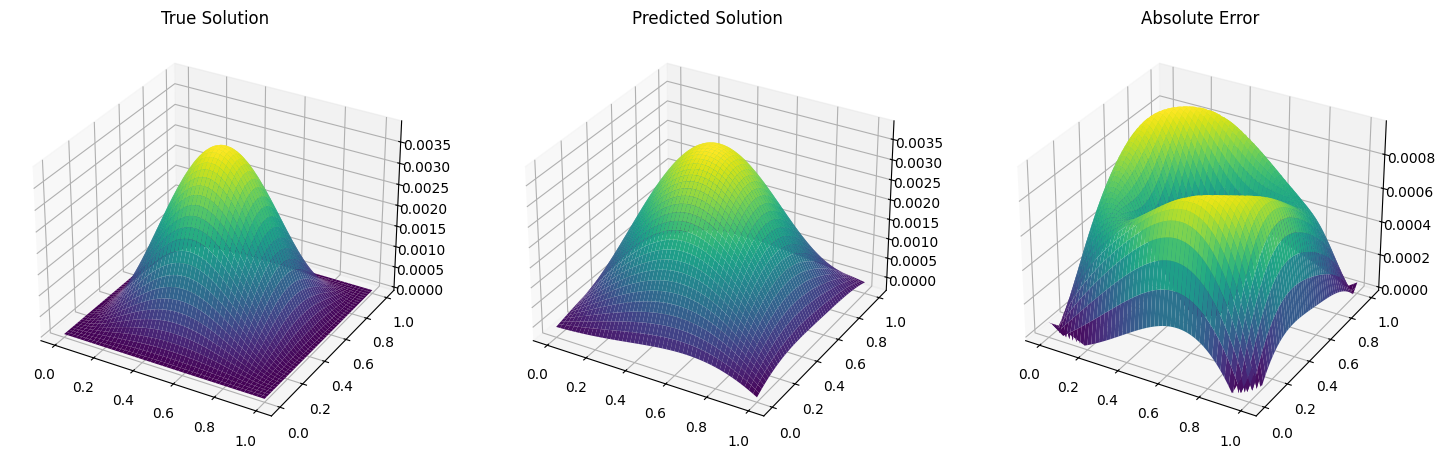

In [18]:
visualize_solution(model,grid_size= 1000)

In [20]:
# losses, interior_losses, boundary_losses = train_(
#     model,
#     adam,
#     None,
#     log_var_interior,
#     log_var_boundary,
#     dirichlet_lambda_start = 5e3,
#     dirichlet_lambda_end = 5e2,
#     epochs = 10000,
#     n_interior = 10000,
#     n_boundary = 4000,
#     print_interval = 50,
#     save_path = 'biharmonic_model_example32_16_56',
#     )

In [21]:
# # Plotting the losses
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.plot(losses, label='Total Loss')
# plt.plot(interior_losses, label='Interior Loss')
# plt.plot(boundary_losses, label='Boundary Loss')
# plt.yscale('log')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Losses')
# plt.legend()
# plt.grid()
# plt.savefig('biharmonic_DRM/training_losses.png')



In [22]:
# import os 
# os.makedirs('biharmonic_DRM_example32',exist_ok=True)
# save_path_ = 'biharmonic_DRM_example32/biharmonic_model_10000epochs.pt'
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': adam.state_dict(),
#     'log_var_interior': log_var_interior,
#     'log_var_boundary': log_var_boundary
# },save_path_
# )


In [23]:
# model = torch.load('biharmonic_DRM_example31/biharmonic_model_10000epochs.pt')['model_state_dict']


In [24]:
#2d projection visualization
def visualize_solution_2d(model,grid_size : int = 50):
    model.eval()
    device = next(model.parameters()).device
    x = np.linspace(0,1,grid_size)
    y = np.linspace(0,1,grid_size)
    X,Y = np.meshgrid(x,y)
    pts = np.stack([X.flatten(),Y.flatten()],axis=1)
    pts_tensor = torch.tensor(pts,dtype=torch.float32).to(device=device)
    with torch.no_grad():
        u_pred = model(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
        u_true = true_solution(pts_tensor).cpu().numpy().reshape((grid_size,grid_size))
    
    fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(1,3,1)
    ax1.contourf(X,Y,u_true,cmap='turbo')
    ax1.set_title('True Solution')
    fig.colorbar(ax1.contourf(X,Y,u_true,cmap='turbo'), ax=ax1) 
    ax2 = fig.add_subplot(1,3,2)
    ax2.contourf(X,Y,u_pred,cmap='turbo')
    ax2.set_title('Predicted Solution')
    fig.colorbar(ax2.contourf(X,Y,u_pred,cmap='turbo'), ax=ax2) 
    ax3 = fig.add_subplot(1,3,3)
    ax3.contourf(X,Y,np.abs(u_true - u_pred),cmap='turbo')
    ax3.set_title('Absolute Error')
    # add the colorbar
    fig.colorbar(ax3.contourf(X,Y,np.abs(u_true - u_pred),cmap='turbo'), ax=ax3) 
    plt.show()


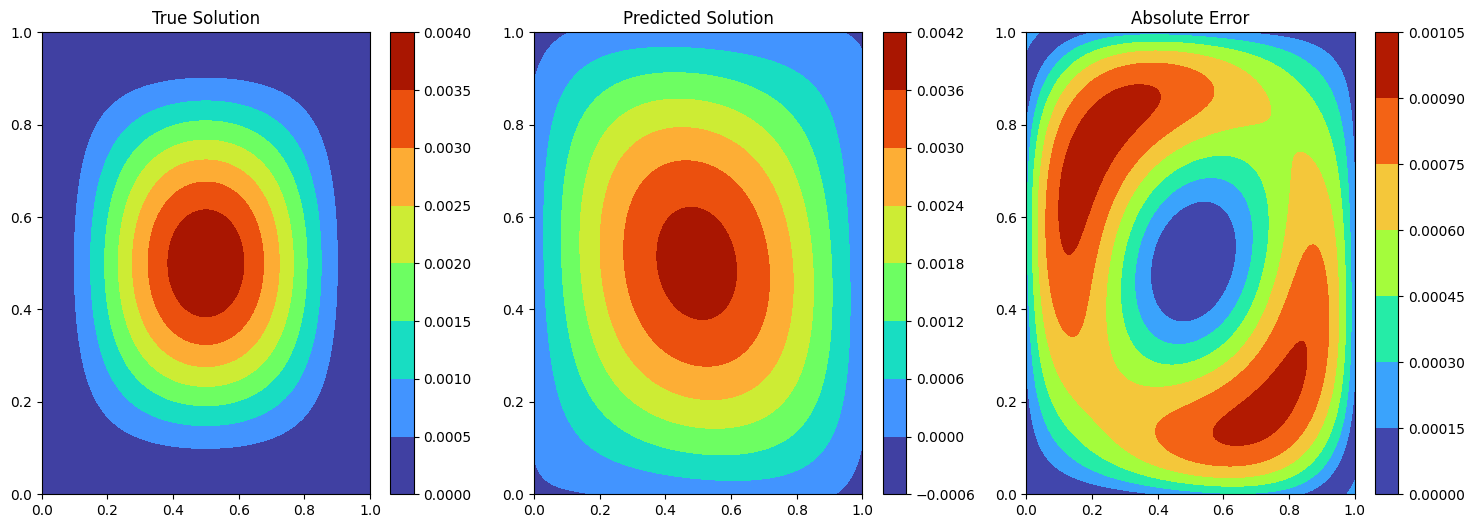

In [ ]:
visualize_solution_2d(model,grid_size=1000)

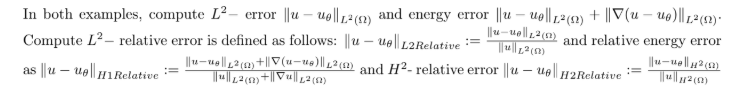

In [19]:

#finding L2 error 


def _make_grid(grid_size, device):
    x = torch.linspace(0.0, 1.0, grid_size, device=device)
    y = torch.linspace(0.0, 1.0, grid_size, device=device)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    pts = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)  # (N,2)
    return pts

def compute_L2_error(model, grid_size: int = 1000):
    """Compute absolute L2 error"""
    model.eval()
    device = next(model.parameters()).device
    pts_tensor = _make_grid(grid_size, device)
    with torch.no_grad():
        u_pred = model(pts_tensor).detach()
        u_true = true_solution(pts_tensor).detach()
    
    l2_error = torch.sqrt(torch.mean((u_pred - u_true) ** 2)).item()
    return l2_error

def compute_L2_relative(model, grid_size: int = 1000, eps: float = 1e-12):
    """Compute relative L2 error"""
    model.eval()
    device = next(model.parameters()).device
    pts_tensor = _make_grid(grid_size, device)
    with torch.no_grad():
        u_pred = model(pts_tensor).detach()
        u_true = true_solution(pts_tensor).detach()
    
    numerator = torch.sqrt(torch.mean((u_pred - u_true) ** 2)).item()
    denominator = torch.sqrt(torch.mean(u_true ** 2)).item() + eps
    rel_error = numerator / denominator
    return rel_error

def compute_H1_relative(model, grid_size: int = 1000, eps: float = 1e-12):
    """
    Compute relative H1 error:
    ||u - u_h||_H1 / ||u||_H1
    where ||v||_H1^2 = ||v||_L2^2 + ||grad(v)||_L2^2
    """
    model.eval()
    device = next(model.parameters()).device
    pts_tensor = _make_grid(grid_size, device)
    pts_tensor.requires_grad = True
    
    u_pred = model(pts_tensor)
    u_true = true_solution(pts_tensor)
    
    # Compute L2 norms
    diff_L2_sq = torch.mean((u_pred - u_true) ** 2).item()
    true_L2_sq = torch.mean(u_true ** 2).item()
    
    # Compute gradients
    u_pred_grad = torch.autograd.grad(u_pred, pts_tensor, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_true_grad = torch.autograd.grad(u_true, pts_tensor, grad_outputs=torch.ones_like(u_true), create_graph=True)[0]
    
    # Compute gradient L2 norms
    grad_diff_L2_sq = torch.mean((u_pred_grad - u_true_grad) ** 2).item()
    grad_true_L2_sq = torch.mean(u_true_grad ** 2).item()
    
    # H1 norms
    numerator = torch.sqrt(torch.tensor(diff_L2_sq + grad_diff_L2_sq)).item()
    denominator = torch.sqrt(torch.tensor(true_L2_sq + grad_true_L2_sq)).item() + eps
    
    return numerator / denominator

def compute_H2_relative(model, grid_size: int = 1000, eps: float = 1e-12):
    """
    Compute relative H2 error:
    ||u - u_h||_H2 / ||u||_H2
    where ||v||_H2^2 = ||v||_L2^2 + ||grad(v)||_L2^2 + ||D^2(v)||_L2^2
    """
    model.eval()
    device = next(model.parameters()).device
    pts_tensor = _make_grid(grid_size, device)
    pts_tensor.requires_grad = True
    
    u_pred = model(pts_tensor)
    u_true = true_solution(pts_tensor)
    
    # L2 norms
    diff_L2_sq = torch.mean((u_pred - u_true) ** 2).item()
    true_L2_sq = torch.mean(u_true ** 2).item()
    
    # Gradient norms
    u_pred_grad = torch.autograd.grad(u_pred, pts_tensor, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_true_grad = torch.autograd.grad(u_true, pts_tensor, grad_outputs=torch.ones_like(u_true), create_graph=True)[0]
    
    grad_diff_L2_sq = torch.mean((u_pred_grad - u_true_grad) ** 2).item()
    grad_true_L2_sq = torch.mean(u_true_grad ** 2).item()
    
    # Hessian norms (Frobenius norm)
    Hessian_pred = compute_hessian(u_pred, pts_tensor)
    Hessian_true = compute_hessian(u_true, pts_tensor)
    
    hess_diff = Hessian_pred - Hessian_true
    hess_diff_L2_sq = torch.mean(torch.sum(hess_diff**2, dim=(1, 2))).item()
    hess_true_L2_sq = torch.mean(torch.sum(Hessian_true**2, dim=(1, 2))).item()
    
    # H2 norms
    numerator = torch.sqrt(torch.tensor(diff_L2_sq + grad_diff_L2_sq + hess_diff_L2_sq)).item()
    denominator = torch.sqrt(torch.tensor(true_L2_sq + grad_true_L2_sq + hess_true_L2_sq)).item() + eps
    
    return numerator / denominator


In [27]:
torch.cuda.empty_cache()

In [22]:
L2_relative = compute_L2_relative(model, grid_size=1000)
print(f"L2 Relative Error: {L2_relative}")


L2 Relative Error: 0.376539633146755


In [25]:
L2_error = compute_L2_error(model, grid_size=1000)
print(f"L2 Error: {L2_error}")

L2 Error: 0.0005970842321403325


In [26]:
H1_relative = compute_H1_relative(model, grid_size=500)
print(f"H1 Relative Error: {H1_relative}")


H1 Relative Error: 0.5056114304414486


c:\Users\kumar\venvs\py312\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [28]:
H2_relative = compute_H2_relative(model, grid_size=250)
print(f"H2 Relative Error: {H2_relative}")


H2 Relative Error: 0.8424360131116138
